![](../../../../Documents/Screenshots/screenshot.286.jpg)
![](../../../../Documents/Screenshots/screenshot.284.jpg)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python.ops.init_ops_v2 import glorot_uniform
from keras.layers import ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from keras import Sequential
from keras.callbacks import ModelCheckpoint


In [2]:

from keras.layers import RandomBrightness

shape = (105, 105, 1)


def convolutional_block(filters):
    f1, f2, f3 = filters

    return [
        Conv2D(f1, (1, 1), strides=(1, 1), kernel_initializer=glorot_uniform(seed=0)),
        MaxPooling2D((2, 2)),
        BatchNormalization(axis=3),
        Activation('relu'),

        Conv2D(f2, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0)),
        BatchNormalization(axis=3),
        Activation('relu'),

        Conv2D(f3, (1, 1), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0)),
        BatchNormalization(axis=3),

        Conv2D(f3, (1, 1), strides=(1, 1), kernel_initializer=glorot_uniform(seed=0)),
        MaxPooling2D((2, 2)),
        BatchNormalization(axis=3),

        Activation('relu')
    ]


def identity_block(filters):
    f1, f2, f3 = filters

    return [
        Conv2D(f1, (1, 1), strides=(1, 1), kernel_initializer=glorot_uniform(seed=0)),
        BatchNormalization(axis=3),
        Activation('relu'),

        Conv2D(f2, (3, 3), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0)),
        BatchNormalization(axis=3),
        Activation('relu'),

        Conv2D(f3, (1, 1), strides=(1, 1), kernel_initializer=glorot_uniform(seed=0)),
        BatchNormalization(axis=3),
        Activation('relu')
    ]


def res_block(model, filters):
    layers = []

    layers.extend(convolutional_block(filters))
    layers.extend(identity_block(filters))
    layers.extend(identity_block(filters))

    for layer in layers:
        model.add(layer)


def resnet():
    model = Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape=shape))
    model.add(Conv2D(64, (7, 7), strides= (2, 2), name='conv1'))
    model.add(BatchNormalization(axis=3, name='bn_conv1'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2)))

    res_block(model, [64, 64, 256])
    res_block(model, [128, 128, 512])

    model.add(AveragePooling2D((4, 4), padding='same', name='avg_pool'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0)))

    return model


In [3]:
model = resnet()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 111, 111, 1)      0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 53, 53, 64)        3200      
                                                                 
 bn_conv1 (BatchNormalizatio  (None, 53, 53, 64)       256       
 n)                                                              
                                                                 
 activation (Activation)     (None, 53, 53, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 64)       0         
 )                                                               
                                                        

In [4]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [5]:
original_data = pd.read_csv('datasets/icml_face_data.csv')
original_data

,emotion,pixels
0,0.0,0.2744 0.3137 0.3215 0.2825 0.2274 0.2274 0.23...
1,0.0,0.5923 0.5884 0.5767 0.608 0.5806 0.5215 0.435...
2,2.0,0.0941 0.1255 0.1412 0.1177 0.1255 0.0902 0.07...
3,2.0,0.0784 0.06665 0.0745 0.08234 0.098 0.149 0.16...
4,3.0,0.302 0.306 0.3098 0.3098 0.306 0.2942 0.2354 ...
...,...,...
24563,3.0,0.0 0.153 0.3176 0.3137 0.408 0.3804 0.2 0.251...
24564,0.0,0.71 0.6943 0.6904 0.612 0.698 0.565 0.533 0.5...
24565,3.0,0.698 0.682 0.6743 0.678 0.71 0.7373 0.749 0.7...
24566,0.0,0.06665 0.06665 0.06274 0.0902 0.1098 0.0863 0...


In [6]:
emotion_dict =  {0:'Ira', 1:'Asco', 2:'Tristeza', 3:'Felicidad', 4: 'Sorpresa'}

In [7]:
original_data['emotion'].value_counts()

3.0    8989
2.0    6077
0.0    4953
4.0    4002
1.0     547
Name: emotion, dtype: int64

In [8]:
from scipy import ndimage

# augmenting data to have balanced classes
augmented_data = original_data.copy()

for emotion in [0, 1, 2, 4]:
    emotion_data = original_data[original_data['emotion'] == emotion].iloc[:2000]

    while True:

        def rotate_image(image):
            image = np.array(image.split(' ')).reshape(48, 48).astype(np.float32)
            image = ndimage.rotate(image, np.random.randint(-25, 25), reshape=False)
            image = image.reshape(-1)

            return ' '.join(map(str, image))

        def set_image_brightness(image):
            image = np.array(image.split(' ')).astype(np.float32)
            image = np.array(image * np.random.randint(0, 2)).reshape(-1)

            return ' '.join(map(str, image))

        method_choices = [rotate_image, set_image_brightness]

        def augment_images(image):
            return np.random.choice(method_choices)(image)

        augmented_data_by_emotion = emotion_data[' pixels'].apply(augment_images)
        augmented_data_by_emotion = pd.DataFrame(augmented_data_by_emotion)
        augmented_data_by_emotion['emotion'] = emotion

        if augmented_data.loc[original_data['emotion'] == emotion].shape[0] > 7500:
            break

        augmented_data = pd.concat([augmented_data, augmented_data_by_emotion])

augmented_data = augmented_data.sample(frac=1).reset_index(drop=True)
augmented_data['emotion'].value_counts()

3.0    8989
0.0    8953
2.0    8077
4.0    8002
1.0    7658
Name: emotion, dtype: int64

In [9]:
from skimage.transform import resize
from keras_preprocessing.image import ImageDataGenerator

# augmented_data = original_data.copy()

def preprocess_image(image):
    image = np.array(image.split(' ')).reshape(48, 48).astype(np.float32)
    image = resize(image, (shape[0], shape[1]), anti_aliasing=True)

    return image

images = augmented_data[' pixels'].apply(preprocess_image)
print(images.shape)

(41679,)


In [10]:
images = list(map(lambda image: image.reshape(shape), images))
images = np.array(images)
images.shape

(41679, 105, 105, 1)

In [11]:
train_x, test_x, train_y, test_y = train_test_split(images, augmented_data['emotion'], test_size=0.2, random_state=42)

checkpointer = ModelCheckpoint(filepath = "models/emotionPredictor.h5", verbose = 1, save_best_only = True)

In [13]:
model.fit(train_x, train_y, epochs=300, validation_data=(test_x, test_y), callbacks=[checkpointer])

Epoch 1/300
  36/1042 [>.............................] - ETA: 2:09 - loss: 2.1321 - accuracy: 0.2049

KeyboardInterrupt: 

261/261 [==============================] - 10s 37ms/step - loss: 0.4564 - accuracy: 0.8222
[0.4563986659049988, 0.8222168684005737]
261/261 [==============================] - 9s 35ms/step


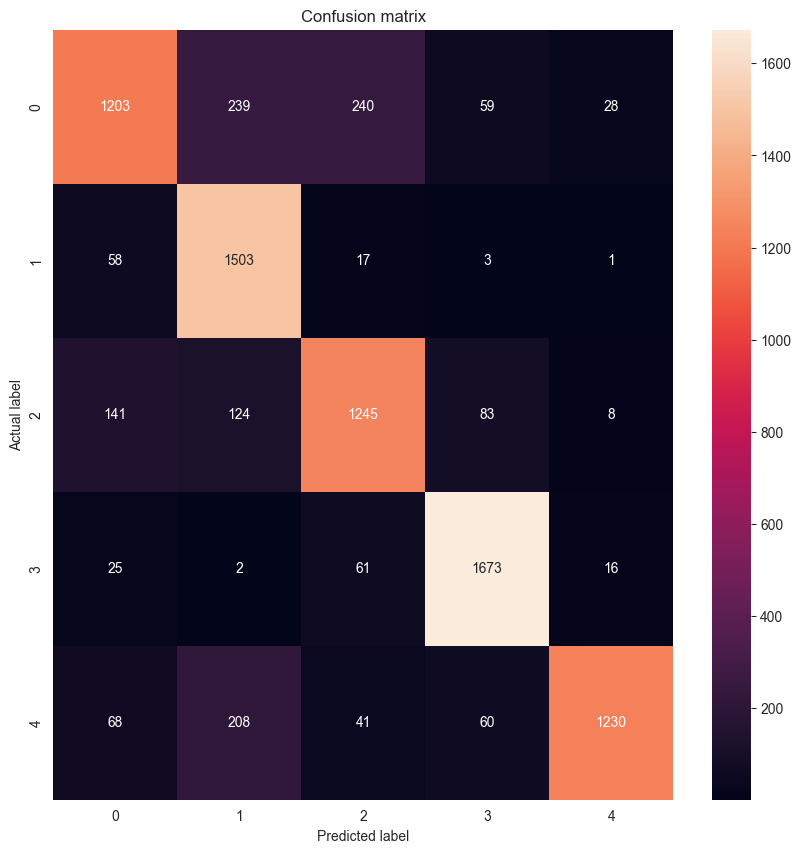

In [14]:
from matplotlib import pyplot as plt
# dispersion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

model = load_model('models/emotionPredictor.h5')

print(model.evaluate(test_x, test_y))

y_pred = model.predict(test_x)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_y, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


In [25]:
import cv2

cap = cv2.VideoCapture(0)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
glassesCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_lowerbody.xml')

if not cap.isOpened():
    print("Cannot open camera")
    exit()

cont = 0
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Our operations on the frame come here

    frame = cv2.flip(frame, 90)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = faceCascade.detectMultiScale(frame, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        frame_cara = cv2.resize(frame[y:y+h, x:x+w], shape[:2])/255

        # set rectangle
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        emotion_index = np.argmax(model.predict(frame_cara.reshape(1, shape[0], shape[1], 1)))

        print(model.predict(frame_cara.reshape(1, shape[0], shape[1], 1)).astype(np.float32))

        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        color = (255, 0, 0)
        thickness = 2

        cv2.putText(frame, 'Emotion: ' + emotion_dict[emotion_index], (50, 50), font,
                            fontScale, color, thickness, cv2.LINE_AA)

    # Display the resulting frame
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'):
        break

    cont += 1
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 22ms/step
[[0.62745098 0.60392157 0.57647059 ... 0.48235294 0.47058824 0.47058824]
 [0.63137255 0.62352941 0.58823529 ... 0.48235294 0.48235294 0.49019608]
 [0.63137255 0.62352941 0.60784314 ... 0.49019608 0.48235294 0.48627451]
 ...
 [0.70588235 0.69803922 0.69411765 ... 0.50980392 0.41960784 0.34117647]
 [0.6627451  0.65490196 0.64705882 ... 0.50980392 0.44313725 0.34117647]
 [0.62352941 0.63137255 0.63921569 ... 0.51764706 0.49411765 0.36862745]]
1/1 [==============================] - 0s 24ms/step
[[7.4165575e-02 3.2359469e-04 3.7557507e-01 5.4770613e-01 2.2296340e-03]]
1/1 [==============================] - 0s 21ms/step
[[0.89019608 0.89019608 0.89803922 ... 0.48627451 0.47843137 0.47843137]
 [0.90196078 0.90196078 0.89019608 ... 0.48235294 0.47843137 0.47058824]
 [0.91764706 0.90588235 0.89019608 ... 0.48235294 0.47843137 0.47843137]
 ...
 [0.71764706 0.71372549 0.71372549 ... 0.50196078 0.50196078 0.50196078]
 [0.71764706 0.71764706 0.717